# Binomial pricing model


In [15]:
import numpy as np
import pandas as pd
import yfinance as yf 
import warnings
warnings.simplefilter("ignore", UserWarning)
import plotly.graph_objects as go 
from scipy.stats import norm

In [2]:
ticker = "NVDA"
start = "2025-01-01"
end = "2025-8-19"
dt = '1d'
data = yf.download(ticker, start=start, end=end,interval=dt)
data.head()

/var/folders/3l/s4t1bsn973dfhyz_6q842jr00000gn/T/ipykernel_87481/2594377039.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start, end=end,interval=dt)
[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,NVDA,NVDA,NVDA,NVDA,NVDA
Date,,,,,
2025-01-02,138.287674,138.857589,134.608275,135.978049,198247200
2025-01-03,144.446686,144.876609,139.707445,139.987399,229322500
2025-01-06,149.405869,152.135439,147.796143,148.566008,265377400
2025-01-07,140.117371,153.105279,139.987387,153.005289,351782200
2025-01-08,140.087387,143.926764,137.537796,142.556990,227349900


In [3]:
def get_yield(df):
    df.columns = df.columns.get_level_values(0)
    df['Spot'] = df['Close']
    df['log_return'] =  np.log(df['Spot'] / df['Spot'].shift(1))
    df = df.dropna(subset = ['log_return'])
    return df
data = get_yield(data)

In [4]:
def calc_nu(df) : 
    n = len(df)
    dt = 1/252

    return (1/(n*dt))*(df['log_return'].sum())

def vol(df) : 
    n = len(df)
    dt = 1/252
    nu = calc_nu(df)
    return np.sqrt((1/((n-1)*dt))*((df['log_return']-nu*dt)**2).sum())

def yield_rate_vol (df): 
    return [calc_nu(data),vol(df),calc_nu(df)-(1/2)*vol(df)**2]

yield_ = yield_rate_vol (data)
yield_

[0.4466504760048415, 0.5713638504116555, 0.28342215122622516]

In [5]:
def complete_years(data):
    # Obtenir la liste des années dans l'ordre
    min_year, max_year = min(data.keys()), max(data.keys())
    for year in range(min_year, max_year + 1):
        if year not in data:
            data[year] = data[year - 1]
    return dict(sorted(data.items()))


def rf_rate():
    df = pd.read_excel('sofr.xlsx')
    return float(df[ 'Rate (%)'].iloc[-1])


In [7]:
def black_scholes_formula(S, K, T, r, sigma, option_type="call"):
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    
    if option_type == "call":
        price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    elif option_type == "put":
        price = K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)
    else:
        raise ValueError("Type d'option non reconnu. Utilisez 'call' ou 'put'.")
    
    return price


In [8]:
# Paramètres de base
S = data['Close'].iloc[-1]        
K = data['Close'].iloc[-1]   # cette valeur est choisie complétement arbitrairement
T = 3     
# On prend une maturité de trois ans et on suppose que le taux sans risque n'évoluera pas pendant cette période, ni qu'il y aura des tombées de dividende
r = rf_rate()*10**-2      
sigma = vol(data)   


In [16]:
black_scholes_formula(S, K, T, r, sigma, option_type="call")

76.42496811699428

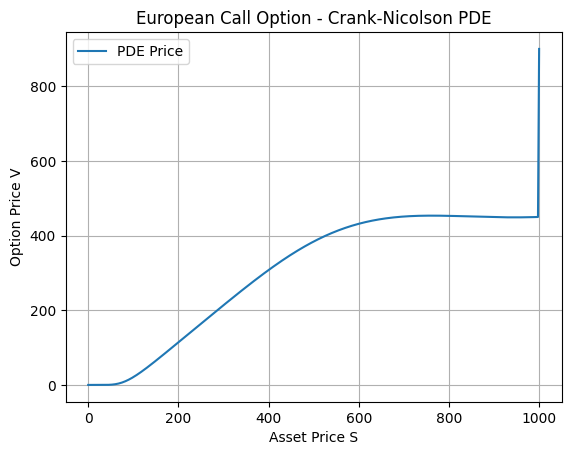

S=50: PDE=0.5654, BS=0.5632
S=80: PDE=8.6259, BS=8.6337
S=100: PDE=20.9156, BS=20.9244
S=120: PDE=37.0612, BS=37.0671
S=150: PDE=64.8244, BS=64.8265
S=300: PDE=213.4539, BS=213.9313
S=500: PDE=384.0582, BS=413.9292
S=800: PDE=452.8771, BS=713.9292


In [34]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# ----------------------------
# 1️⃣ Parameters
# ----------------------------
def get_parameters():
    params = {
        'S_max': 1000,  # S_max très grand pour éviter instabilités
        'K': 100,
        'T': 3.0,
        'r': 0.05,
        'sigma': 0.2,
        'Ns': 400,
        'Nt': 400
    }
    params['dS'] = params['S_max'] / params['Ns']
    params['dt'] = params['T'] / params['Nt']
    params['S'] = np.linspace(0, params['S_max'], params['Ns']+1)
    return params

# ----------------------------
# 2️⃣ Terminal condition
# ----------------------------
def terminal_condition_call(S, K):
    return np.maximum(S - K, 0)

# ----------------------------
# 3️⃣ Compute coefficients
# ----------------------------
def compute_coefficients(params):
    M = params['Ns'] - 1
    S_grid = params['S'][1:-1]
    dS = params['dS']
    dt = params['dt']
    sigma = params['sigma']
    r = params['r']

    alpha = 0.25 * dt * (sigma**2 * S_grid**2 / dS**2 - r * S_grid / dS)
    beta  = -0.5 * dt * (sigma**2 * S_grid**2 / dS**2 + r)
    gamma = 0.25 * dt * (sigma**2 * S_grid**2 / dS**2 + r * S_grid / dS)

    # Tridiagonal matrices
    A = np.zeros((M,M))
    B = np.zeros((M,M))
    for i in range(M):
        if i > 0:
            A[i,i-1] = -alpha[i]
            B[i,i-1] = alpha[i]
        A[i,i] = 1 - beta[i]
        B[i,i] = 1 + beta[i]
        if i < M-1:
            A[i,i+1] = -gamma[i]
            B[i,i+1] = gamma[i]
    return A, B, alpha, gamma

# ----------------------------
# 4️⃣ Crank-Nicolson PDE solver
# ----------------------------
def crank_nicolson(V, A, B, alpha, gamma, params):
    Ns = params['Ns']
    Nt = params['Nt']
    dt = params['dt']
    S_max = params['S_max']
    r = params['r']
    
    for n in range(Nt):
        t = params['T'] - n*dt  # temps courant (backward)
        
        # Boundary conditions
        V0 = 0  # Call at S=0
        V[-1] = S_max - params['K']*np.exp(-r*t)  # analytique pour S_max
        
        # Right-hand side
        rhs = B @ V[1:-1]
        rhs[0] += alpha[0]*V0
        rhs[-1] += gamma[-1]*V[-1]
        
        # Solve tridiagonal system
        V[1:-1] = np.linalg.solve(A, rhs)
        
        # Apply boundary at left
        V[0] = V0
        
    return V

# ----------------------------
# 5️⃣ Black-Scholes formula
# ----------------------------
def black_scholes_call(S, K, T, r, sigma):
    d1 = (np.log(S/K) + (r + 0.5*sigma**2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    return S*norm.cdf(d1) - K*np.exp(-r*T)*norm.cdf(d2)

# ----------------------------
# 6️⃣ Plot results
# ----------------------------
def plot_results(S, V):
    plt.plot(S, V, label='PDE Price')
    plt.xlabel("Asset Price S")
    plt.ylabel("Option Price V")
    plt.title("European Call Option - Crank-Nicolson PDE")
    plt.grid(True)
    plt.legend()
    plt.show()

# ----------------------------
# 7️⃣ Compare PDE with Black-Scholes
# ----------------------------
def compare_with_bs(S, V, K, T, r, sigma):
    S0 = np.array([50, 80, 100, 120, 150, 300, 500, 800])
    for s0 in S0:
        pde_price = np.interp(s0, S, V)
        bs_price = black_scholes_call(s0, K, T, r, sigma)
        print(f"S={s0}: PDE={pde_price:.4f}, BS={bs_price:.4f}")

# ----------------------------
# Main
# ----------------------------
def main():
    params = get_parameters()
    V = terminal_condition_call(params['S'], params['K'])
    A, B, alpha, gamma = compute_coefficients(params)
    V = crank_nicolson(V, A, B, alpha, gamma, params)
    plot_results(params['S'], V)
    compare_with_bs(params['S'], V, params['K'], params['T'], params['r'], params['sigma'])

if __name__ == "__main__":
    main()
